In [1]:
import torch
import torch.nn as nn
from pathlib import Path
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def calc_mean_std(feat, eps=1e-5):
    # eps is a small value added to the variance to avoid divide-by-zero.
    size = feat.size()
    assert (len(size) == 4)
    N, C = size[:2]
    feat_var = feat.view(N, C, -1).var(dim=2) + eps
    feat_std = feat_var.sqrt().view(N, C, 1, 1)
    feat_mean = feat.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return feat_mean, feat_std


def adain(content_feat, style_feat):
    assert (content_feat.size()[:2] == style_feat.size()[:2])
    size = content_feat.size()
    style_mean, style_std = calc_mean_std(style_feat)
    content_mean, content_std = calc_mean_std(content_feat)

    normalized_feat = (content_feat - content_mean.expand(
        size)) / content_std.expand(size)
    return normalized_feat * style_std.expand(size) + style_mean.expand(size)


def _calc_feat_flatten_mean_std(feat):
    # takes 3D feat (C, H, W), return mean and std of array within channels
    assert (feat.size()[0] == 3)
    assert (isinstance(feat, torch.FloatTensor))
    feat_flatten = feat.view(3, -1)
    mean = feat_flatten.mean(dim=-1, keepdim=True)
    std = feat_flatten.std(dim=-1, keepdim=True)
    return feat_flatten, mean, std


def _mat_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())


def coral(source, target):
    # assume both source and target are 3D array (C, H, W)
    # Note: flatten -> f

    source_f, source_f_mean, source_f_std = _calc_feat_flatten_mean_std(source)
    source_f_norm = (source_f - source_f_mean.expand_as(
        source_f)) / source_f_std.expand_as(source_f)
    source_f_cov_eye = \
        torch.mm(source_f_norm, source_f_norm.t()) + torch.eye(3)

    target_f, target_f_mean, target_f_std = _calc_feat_flatten_mean_std(target)
    target_f_norm = (target_f - target_f_mean.expand_as(
        target_f)) / target_f_std.expand_as(target_f)
    target_f_cov_eye = \
        torch.mm(target_f_norm, target_f_norm.t()) + torch.eye(3)

    source_f_norm_transfer = torch.mm(
        _mat_sqrt(target_f_cov_eye),
        torch.mm(torch.inverse(_mat_sqrt(source_f_cov_eye)),
                 source_f_norm)
    )

    source_f_transfer = source_f_norm_transfer * \
                        target_f_std.expand_as(source_f_norm) + \
                        target_f_mean.expand_as(source_f_norm)

    return source_f_transfer.view(source.size())

In [3]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)

vgg = nn.Sequential(
    nn.Conv2d(3, 3, (1, 1)),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(3, 64, (3, 3)),
    nn.ReLU(),  # relu1-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),  # relu1-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 128, (3, 3)),
    nn.ReLU(),  # relu2-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),  # relu2-2
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 256, (3, 3)),
    nn.ReLU(),  # relu3-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),  # relu3-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 512, (3, 3)),
    nn.ReLU(),  # relu4-1, this is the last layer used
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu4-4
    nn.MaxPool2d((2, 2), (2, 2), (0, 0), ceil_mode=True),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-1
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-2
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU(),  # relu5-3
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 512, (3, 3)),
    nn.ReLU()  # relu5-4
)


class Net(nn.Module):
    def __init__(self, encoder, decoder):
        super(Net, self).__init__()
        enc_layers = list(encoder.children())
        self.enc_1 = nn.Sequential(*enc_layers[:4])  # input -> relu1_1
        self.enc_2 = nn.Sequential(*enc_layers[4:11])  # relu1_1 -> relu2_1
        self.enc_3 = nn.Sequential(*enc_layers[11:18])  # relu2_1 -> relu3_1
        self.enc_4 = nn.Sequential(*enc_layers[18:31])  # relu3_1 -> relu4_1
        self.decoder = decoder
        self.mse_loss = nn.MSELoss()

        # fix the encoder
        for name in ['enc_1', 'enc_2', 'enc_3', 'enc_4']:
            for param in getattr(self, name).parameters():
                param.requires_grad = False

    # extract relu1_1, relu2_1, relu3_1, relu4_1 from input image
    def encode_with_intermediate(self, input):
        results = [input]
        for i in range(4):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]

    # extract relu4_1 from input image
    def encode(self, input):
        for i in range(4):
            input = getattr(self, 'enc_{:d}'.format(i + 1))(input)
        return input

    def calc_content_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        return self.mse_loss(input, target)

    def calc_style_loss(self, input, target):
        assert (input.size() == target.size())
        assert (target.requires_grad is False)
        input_mean, input_std = calc_mean_std(input)
        target_mean, target_std = calc_mean_std(target)
        return self.mse_loss(input_mean, target_mean) + \
               self.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1.0):
        assert 0 <= alpha <= 1
        style_feats = self.encode_with_intermediate(style)
        content_feat = self.encode(content)
        t = adain(content_feat, style_feats[-1])
        t = alpha * t + (1 - alpha) * content_feat

        g_t = self.decoder(t)
        g_t_feats = self.encode_with_intermediate(g_t)

        loss_c = self.calc_content_loss(g_t_feats[-1], t)
        loss_s = self.calc_style_loss(g_t_feats[0], style_feats[0])
        for i in range(1, 4):
            loss_s += self.calc_style_loss(g_t_feats[i], style_feats[i])
        return loss_c, loss_s
    
def style_transfer(vgg, decoder, content, style, alpha=1.0,
                   interpolation_weights=None, device='cuda'):
    assert (0.0 <= alpha <= 1.0)
    content_f = vgg(content)
    style_f = vgg(style)
    if interpolation_weights:
        _, C, H, W = content_f.size()
        feat = torch.FloatTensor(1, C, H, W).zero_().to(device)
        base_feat = adain(content_f, style_f)
        for i, w in enumerate(interpolation_weights):
            feat = feat + w * base_feat[i:i + 1]
        content_f = content_f[0:1]
    else:
        feat = adain(content_f, style_f)
    feat = feat * alpha + content_f * (1 - alpha)
    return decoder(feat)

def adain_init(device = 'cuda'):
    decoder_adain = decoder
    vgg_adain = vgg

    decoder_adain.eval()
    vgg_adain.eval()

    decoder_adain.load_state_dict(torch.load('models_weights/decoder.pth'))
    vgg_adain.load_state_dict(torch.load('models_weights/vgg_normalised.pth'))
    vgg_adain = nn.Sequential(*list(vgg_adain.children())[:31])

    vgg_adain.to(device)
    decoder_adain.to(device)

    net_adain = Net(vgg_adain, decoder_adain).to(device).eval()
    return vgg_adain, decoder_adain, net_adain


In [4]:

# Define preprocessing (same as used for VGG)
transform = transforms.Compose([
    transforms.Resize(512),  # or smaller (e.g., 256) to save memory
    transforms.CenterCrop(512),
    transforms.ToTensor(),  # converts to [0,1]
])

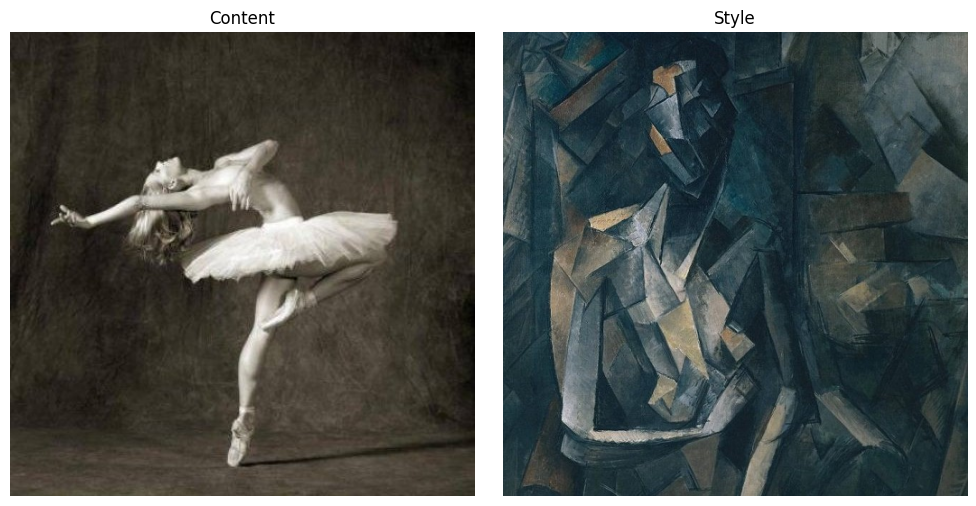

In [5]:
content_image = Image.open("images/content/dancing.jpg")
style_image = Image.open("images/style/picasso.jpg")


# Create the figure
plt.figure(figsize=(10, 5))

# Show content image
plt.subplot(1, 2, 1)
plt.imshow(content_image)
plt.title("Content")
plt.axis("off")

# Show style image
plt.subplot(1, 2, 2)
plt.imshow(style_image)
plt.title("Style")
plt.axis("off")

# Display both
plt.tight_layout()
plt.show()

In [ ]:
# Load image
content = transform(content_image)
style = transform(style_image)
style = coral(style, content)
style = style.to(device).unsqueeze(0) 
content = content.to(device).unsqueeze(0)

In [7]:
vgg, decoder, net = adain_init()

In [ ]:
# Perform style transfer
with torch.no_grad():
    output = style_transfer(net.encode, decoder, content, style, alpha=0.5)
output = output.cpu()

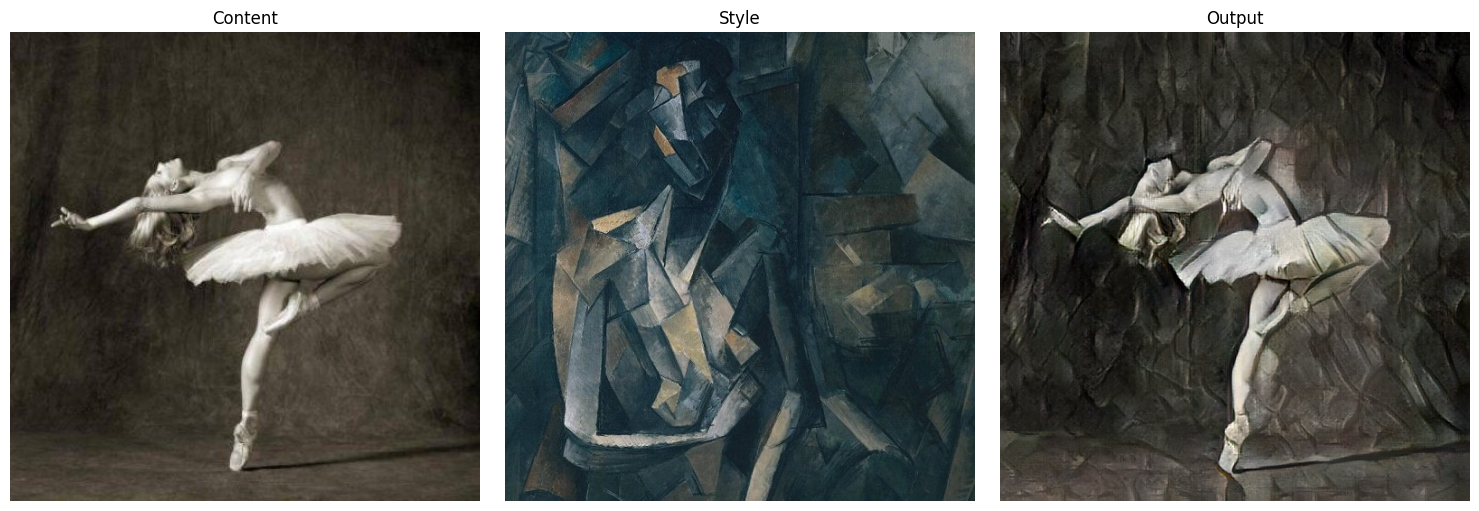

In [9]:
# Convert torch output to PIL image
def tensor_to_pil(tensor):
    tensor = tensor.squeeze(0).clamp(0, 1)  # Remove batch and clamp values to [0,1]
    return transforms.ToPILImage()(tensor)
output_image = tensor_to_pil(output)
# Show all three images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(content_image)
plt.title("Content")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(style_image)
plt.title("Style")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(output_image)
plt.title("Output")
plt.axis("off")

plt.tight_layout()
plt.show()